# Importing libraries

In [1]:
import sys
sys.path.append('../')
from dataset import *
from data_aug import *
import tensorflow as tf
from comparison_model import *
from utils import *
from ranking_model import *

import random
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout, Subtract, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Loading Mapillary data

In [14]:
data = prepare_data("../final_training_query_mapillary.csv")

image1_array, image2_array, labels = prepare_dataset_arrays("../Mapillary/mapillary_training/", data, 224)

labels = labels [1:]

Processing Images:   0%|          | 0/9128 [00:00<?, ?image/s]

Processing Images: 100%|█████████▉| 9126/9128 [05:35<00:00, 27.21image/s]


# Best ranking model from streetview tuning without transfer learning

In [ ]:
batch_size = 64

train_generator, valid_generator, test_generator, train_size, valid_size = prepare_dataset_generators(image1_array, image2_array, labels, batch_size, "ranking")

train_steps_per_epoch = train_size // batch_size
valid_steps_per_epoch = valid_size // batch_size

In [4]:
def create_ranking_network(img_size):
    """
    Create ranking network which give a score to an image.

    :param img_size: size of input images during training
    :type img_size: tuple(int)
    :return: ranking network model
    :rtype: keras.Model
    """
    # Create feature extractor from VGG19
    feature_extractor = VGG19(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))
    for layer in feature_extractor.layers[:-4]:
        layer.trainable = False

    # Add dense layers on top of the feature extractor
    inp = Input(shape=(img_size, img_size, 3), name='input_image')
    base = feature_extractor(inp)
    base = Flatten(name='Flatten')(base)

    # Block 1
    base = Dense(32, activation='sigmoid', name='Dense_1')(base)
    base = BatchNormalization(name='BN1')(base)
    base = Dropout(0.4, name='Drop_1')(base)

    # Block 2
    base = Dense(32, activation='sigmoid', name='Dense_2')(base)
    base = BatchNormalization(name='BN2')(base)
    base = Dropout(0.4, name='Drop_2')(base)

    # Final dense
    base = Dense(1, name="Dense_Output")(base)
    base_network = Model(inp, base, name='Scoring_model')
    return base_network


def create_meta_network(img_size, weights=None):
    """
    Create meta network which is used to to teach the ranking network.

    :param img_size: dimension of input images during training.
    :type img_size: tuple(int)
    :param weights: path to the weights use for initialization
    :type weights: str
    :return: meta network model
    :rtype: keras.Model
    """

    # Create the two input branches
    input_left = Input(shape=(img_size, img_size, 3), name='left_input')
    input_right = Input(shape=(img_size, img_size, 3), name='right_input')
    base_network = create_ranking_network(img_size)
    left_score = base_network(input_left)
    right_score = base_network(input_right)

    # Subtract scores
    diff = Subtract()([left_score, right_score])

    # Pass difference through sigmoid function.
    prob = Activation("sigmoid", name="Activation_sigmoid")(diff)
    model = Model(inputs=[input_left, input_right], outputs= prob, name="Meta_Model")

    if weights:
        print('Loading weights ...')
        model.load_weights(weights)

    model.compile(optimizer=RMSprop(learning_rate=1e-06, decay=1e-05), loss="binary_crossentropy", metrics=['accuracy'])

    return model

meta_model = create_meta_network(224)

In [ ]:
history = meta_model.fit(train_generator,
          steps_per_epoch=train_steps_per_epoch,
          epochs=50,
          validation_data=valid_generator,
          validation_steps=valid_steps_per_epoch)

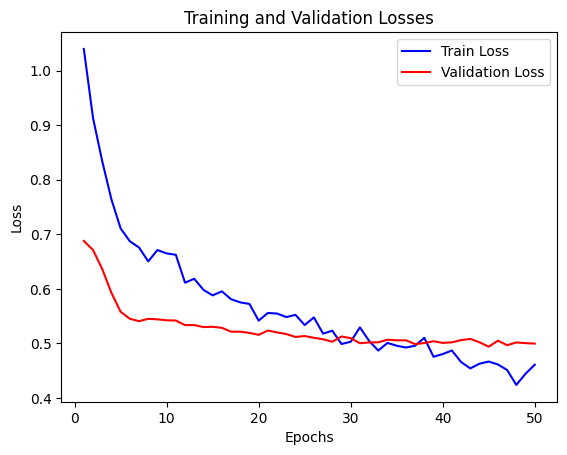

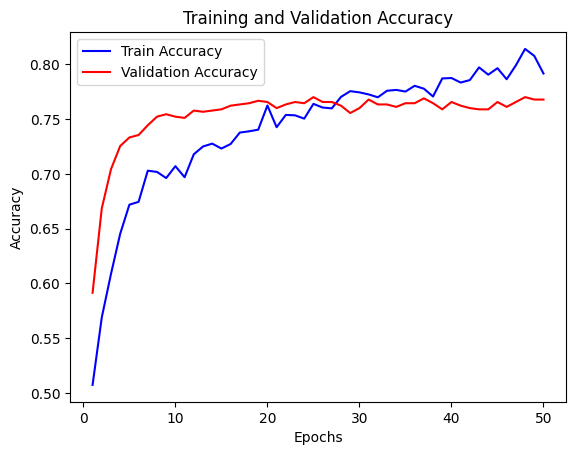

In [18]:
ranking_model = meta_model.get_layer('Scoring_model')
ranking_model.save_weights('ranking_model_weights.h5')
plot_loss(history)
plot_accuracy(history)

## With data augmentation

In [23]:
# labels_2 = labels[1:]
# print(np.unique(labels_2))

['left' 'right']


In [24]:
# save_folder = "../Mapillary/mapillary_training_dataaug"
# image1_array, image2_array, labels = data_aug(image1_array, image2_array, labels_2, save_folder)

In [2]:
image1_array, image2_array, labels = load_data("../Mapillary/mapillary_training_dataaug/")

In [3]:
batch_size = 64

train_generator, valid_generator, test_generator, train_size, valid_size = prepare_dataset_generators(image1_array, image2_array, labels, batch_size, "ranking")

train_steps_per_epoch = train_size // batch_size
valid_steps_per_epoch = valid_size // batch_size

In [5]:
history = meta_model.fit(train_generator,
          steps_per_epoch=train_steps_per_epoch,
          epochs=50,
          validation_data=valid_generator,
          validation_steps=valid_steps_per_epoch)

Epoch 1/50
85/85 [==============================] - 60s 484ms/step - loss: 0.9841 - accuracy: 0.5888 - val_loss: 0.6591 - val_accuracy: 0.6602
Epoch 2/50
85/85 [==============================] - 47s 487ms/step - loss: 0.8746 - accuracy: 0.6393 - val_loss: 0.5909 - val_accuracy: 0.6842
Epoch 3/50
85/85 [==============================] - 41s 485ms/step - loss: 0.8053 - accuracy: 0.6705 - val_loss: 0.5896 - val_accuracy: 0.7037
Epoch 4/50
85/85 [==============================] - 41s 486ms/step - loss: 0.7687 - accuracy: 0.6864 - val_loss: 0.6213 - val_accuracy: 0.7132
Epoch 5/50
85/85 [==============================] - 41s 487ms/step - loss: 0.7435 - accuracy: 0.6947 - val_loss: 0.6205 - val_accuracy: 0.7171
Epoch 6/50
85/85 [==============================] - 41s 485ms/step - loss: 0.7515 - accuracy: 0.7012 - val_loss: 0.6107 - val_accuracy: 0.7299
Epoch 7/50
85/85 [==============================] - 41s 485ms/step - loss: 0.7393 - accuracy: 0.7012 - val_loss: 0.6031 - val_accuracy: 0.7327

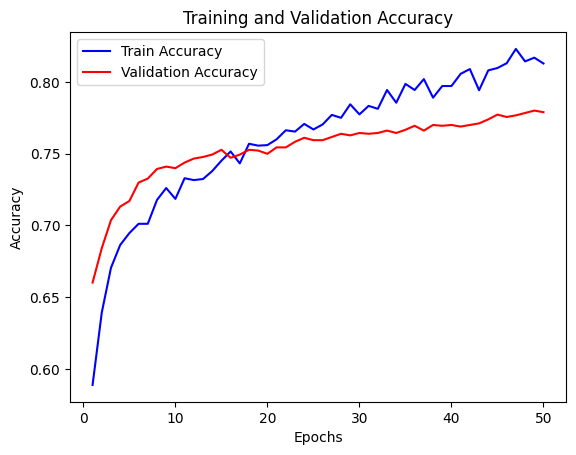

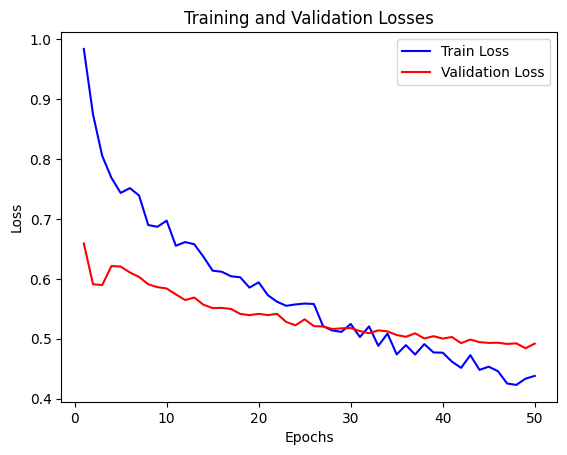

In [6]:
ranking_model = meta_model.get_layer('Scoring_model')
ranking_model.save_weights('ranking_model_weights.h5')
plot_accuracy(history)
plot_loss(history)

# Best comparison model trained with Streetview data

In [7]:
batch_size = 64

train_generator, valid_generator, test_generator, train_size, valid_size = prepare_dataset_generators(image1_array, image2_array, labels, batch_size, "comparison")

train_steps_per_epoch = train_size // batch_size
valid_steps_per_epoch = valid_size // batch_size

In [8]:
def comparison_siamese_model(input_shape):
    """Create a siamese model for image comparison using VGG19 as base model.

    Args:
        input_shape (tuple): Shape of the input images.
    Returns:
        keras.models.Model: The compiled siamese model.
    """
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-4]:
        layer.trainable=False

    # Create inputs for pairs of images
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)

    # Get embeddings of the images using the shared VGG19 model
    output_1 = base_model(input_1)
    output_2 = base_model(input_2)

    concat = concatenate([output_1, output_2])

    # Classification layer to predict similarity
    flatten = Flatten()(concat)
    x = Conv2D(32, (3, 3), activation="tanh", padding='same')(concat)
    x = Dropout(0.3)(x)
    x = Conv2D(32, (3, 3), activation="tanh", padding='same')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    output = Dense(2, activation='sigmoid')(x)

    # Create the complete siamese model
    siamese_model = Model(inputs=[input_1, input_2], outputs=output)

    # Compile the model with the provided hyperparameters
    siamese_model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-05, decay=0.001), metrics=['accuracy'])

    # Print model summary
    siamese_model.summary()

    return siamese_model

siamese_model = comparison_siamese_model((224,224,3))

siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 512)    20024384    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 7, 7, 1024)   0           vgg19[0][0]                  

In [ ]:
history = siamese_model.fit(train_generator,
          steps_per_epoch=train_steps_per_epoch,
          epochs=50,
          validation_data=valid_generator,
          validation_steps=valid_steps_per_epoch)

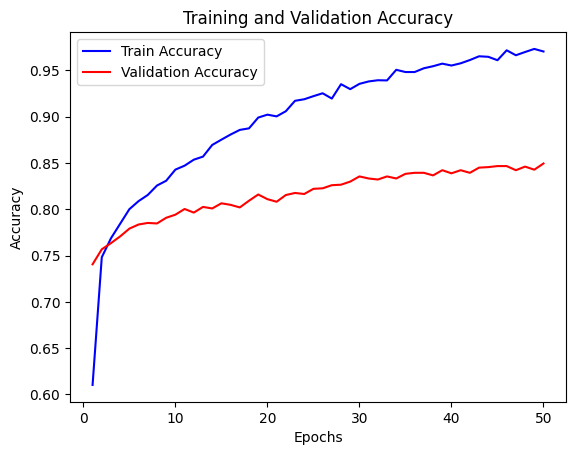

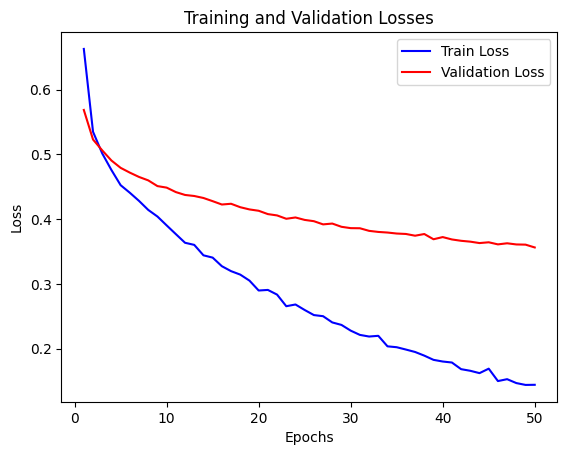

In [9]:
plot_accuracy(history)
plot_loss(history)

siamese_model.save("comparison.h5")

# Best comparison model trained with Mapillary data fine tuned

In [ ]:
# Define hyperparameter search space with wider ranges
hyperparameters = {
    'dense_units': [32, 64, 128, 256, 512],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6],
    'learning_rate': [0.0001, 0.00001, 0.000001],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'learning_rate_decay': [0.001, 0.0001, 0.00001]
}

In [ ]:
def comparison_siamese_model(input_shape, dense_units, dropout_rate, learning_rate, optimizer, learning_rate_decay, activation):
    """Create a siamese model for image comparison using VGG19 as base model.

    Args:
        input_shape (tuple): Shape of the input images.
        dense_units (int): Number of units in the dense layers.
        dropout_rate (float): Dropout rate.
        learning_rate (float): Learning rate for the optimizer.
        optimizer (str): Optimizer algorithm.
        activation (str): Activation function for the dense layers.

    Returns:
        keras.models.Model: The compiled siamese model.
    """
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-4]:
        layer.trainable=False

    # Create inputs for pairs of images
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)

    # Get embeddings of the images using the shared VGG19 model
    output_1 = base_model(input_1)
    output_2 = base_model(input_2)

    concat = concatenate([output_1, output_2])

    # Classification layer to predict similarity
    flatten = Flatten()(concat)
    x = Conv2D(dense_units, (3, 3), activation=activation, padding='same')(concat)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(dense_units, (3, 3), activation=activation, padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)
    output = Dense(2, activation='sigmoid')(x)

    # Create the complete siamese model
    siamese_model = Model(inputs=[input_1, input_2], outputs=output)

    if optimizer == "adam":
        optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay)
    elif optimizer == "sgd":
        optimizer = SGD(learning_rate=learning_rate, decay=learning_rate_decay)
    elif optimizer == "rmsprop":
        optimizer = RMSprop(learning_rate=learning_rate, decay=learning_rate_decay)
    else:
        raise ValueError("Unsupported optimizer: " + optimizer)

    # Compile the model with the provided hyperparameters
    siamese_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

    # Print model summary
    siamese_model.summary()

    return siamese_model

In [ ]:
# Initialize best hyperparameters and best validation accuracy
best_hyperparameters = None
best_test_loss = 100

# Define the number of random combinations to try
num_random_combinations = 70

# Perform random search
for _ in range(num_random_combinations):
    # Generate random combination of hyperparameters
    combination = {
        param: random.choice(values)
        for param, values in hyperparameters.items()
    }
    print(combination)
    # Create and train the model with the current hyperparameters
    model = comparison_siamese_model((224,224,3), **combination)
    
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

    # Train the model
    history = model.fit(train_generator,
          steps_per_epoch=train_steps_per_epoch,
          epochs=50,
          validation_data=valid_generator,
          validation_steps=valid_steps_per_epoch,
          callbacks=[early_stopping])
    
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_generator, steps=valid_steps_per_epoch)
    
    # Check if the current model has the best test accuracy so far
    if best_test_loss > test_loss:
        best_hyperparameters = combination
        best_test_loss = test_loss
        # Save the weights of the best model
        model.save_weights('best_model_weights.h5')
        plot_accuracy(history)
        plot_loss(history)

        # Print the best hyperparameters and best test accuracy
        print('Best Hyperparameters:', best_hyperparameters)
        print('Best Test Loss:', best_test_loss)

# Best ranking model trained with Mapillary data fine tuned

In [ ]:
#TO-DO